In [1]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
!pip install pandas-bokeh

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [3]:
import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [4]:
url1 = "https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12"
download_unzip(url1)
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")

url2 = "https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
arrondissements = gpd.read_file(url2)

url3 = "https://www.data.gouv.fr/fr/datasets/r/322480e7-824b-402d-8dec-ebff968a161d"
camping = gpd.read_file(url3)

url4 = "https://www.data.gouv.fr/fr/datasets/r/6987b47d-7d97-4e3d-8508-ac924c48fc95"
hopitaux = gpd.read_file(url4)

url5 = "https://www.data.gouv.fr/fr/datasets/r/52b2a283-7171-426d-99e1-63efe071cdf0"
police = gpd.read_file(url5)

url6 = "https://www.data.gouv.fr/fr/datasets/r/058154d2-a462-48b7-b726-b77905d16be9"
mobile = gpd.read_file(url6)

url7 = "https://www.data.gouv.fr/fr/datasets/r/86ea48a0-dd94-4a23-b71c-80d3041d7db2"
defibrillateurs = gpd.read_file(url7)

In [5]:
arrondissements = arrondissements.rename(columns = {"c_arinsee" : "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)
communes = communes[~communes.insee.str.startswith("75")].append(arrondissements)
communes["dep"] = communes.insee.str[:2]

In [6]:
#communes.head()
#camping.head()
#hopitaux.head()
#police.head()
#mobile.head()

In [7]:
def proj_4326(x) :
    x.crs = {'init' :'epsg:4326'}
    x = x.to_crs(epsg = 4326)
    return x

In [8]:
communes_idf = communes[communes['dep'].isin(['75', '92', '93', '94', '78', '91', '77', '95'])]

In [9]:
communes_idf = communes_idf[["insee", "nom", "surf_ha", "geometry", "dep"]]
communes_idf["type"] = "communes"
communes_idf = communes_idf.rename(columns = {"nom" : "Nom", "surf_ha" : "Surface"})
#communes_idf.head()

In [10]:
idf_polygon = communes[communes['dep'].isin(['75', '92', '93', '94', '78', '91', '77', '95'])].geometry.unary_union
paris_polygon = communes[communes['dep'].isin(['75'])].geometry.unary_union
essonne_polygon = communes[communes['dep'].isin(['91'])].geometry.unary_union
yvelines_polygon = communes[communes['dep'].isin(['78'])].geometry.unary_union
valdoise_polygon = communes[communes['dep'].isin(['95'])].geometry.unary_union
seineetmarne_polygon = communes[communes['dep'].isin(['77'])].geometry.unary_union
hautsdeseine_polygon = communes[communes['dep'].isin(['92'])].geometry.unary_union
seinesaintdenis_polygon = communes[communes['dep'].isin(['93'])].geometry.unary_union
valdemarne_polygon = communes[communes['dep'].isin(['94'])].geometry.unary_union

idf_polygon_df = gpd.GeoDataFrame(geometry = [idf_polygon])
paris_polygon_df = gpd.GeoDataFrame(geometry = [paris_polygon])
essonne_polygon_df = gpd.GeoDataFrame(geometry = [essonne_polygon])
yvelines_polygon_df = gpd.GeoDataFrame(geometry = [yvelines_polygon])
valdoise_polygon_df = gpd.GeoDataFrame(geometry = [valdoise_polygon])
seineetmarne_polygon_df = gpd.GeoDataFrame(geometry = [seineetmarne_polygon])
hautsdeseine_polygon_df = gpd.GeoDataFrame(geometry = [hautsdeseine_polygon])
seinesaintdenis_polygon_df = gpd.GeoDataFrame(geometry = [seinesaintdenis_polygon])
valdemarne_polygon_df = gpd.GeoDataFrame(geometry = [valdemarne_polygon])

In [11]:
frames = [paris_polygon_df, essonne_polygon_df, valdemarne_polygon_df, seineetmarne_polygon_df, yvelines_polygon_df, seinesaintdenis_polygon_df, hautsdeseine_polygon_df, valdoise_polygon_df]
departements_idf = pd.concat(frames)

In [12]:
departements_idf = proj_4326(departements_idf)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
departements_idf["type"] = "departements"
#departements_idf.head()

In [14]:
camping["classement"] = camping["classement"].str[:1].astype(int)

In [15]:
surface_3etoiles = camping[camping["classement"] <= 3]["nombre_d_emplacements"]/100
surface_5etoiles = camping[camping["classement"] >= 4]["nombre_d_emplacements"]/80
camping["surface"] = pd.concat([surface_3etoiles, surface_5etoiles])
camping["surface"] = camping["surface"]*10000 

In [16]:
camping["permanence_24h"] = 1*(camping["classement"] >= 3)
camping["langues_accueil"] = 1*(camping["classement"] <= 5) + 2*(camping["classement"] >= 3) + 1*(camping["classement"] == 5)
camping["internet_partout"] = 1*(camping["classement"] >= 4)

In [17]:
camping = camping.rename(columns = {"nom_commercial" : "Nom", "adresse" : "Adresse", "nombre_d_emplacements" : "Emplacements", "classement" : "Classement", "surface" : "Surface"})

In [18]:
camping = proj_4326(camping)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
camping = camping[["Adresse", "dep", "Emplacements", "Nom", "Classement", "commune", "code_postal", "geometry", "Surface", "permanence_24h", "langues_accueil", "internet_partout"]]
camping["type"] = "camping"
#camping.head()

In [20]:
hopitaux_idf = hopitaux[hopitaux["geometry"].within(idf_polygon)]
hopitaux_idf["geometry"] = hopitaux_idf["geometry"].centroid

/tmp/ipykernel_3339/2663001065.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hopitaux_idf["geometry"] = hopitaux_idf["geometry"].centroid
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
hopitaux_idf = proj_4326(hopitaux_idf)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [22]:
hopitaux_idf = hopitaux_idf[["name", "geometry", "addr:housenumber", "addr:street", "addr:postcode", "addr:city"]]
hopitaux_idf["type"] = "hopitaux"
hopitaux_idf = hopitaux_idf.rename(columns = {"addr:housenumber" : "numero_hab", "addr:street" : "rue", "addr:postcode" : "code_postal", "addr:city" : "ville", "name" : "Nom"})
#hopitaux_idf.head()

In [23]:
police = police.to_crs(epsg = 4326)

In [24]:
police_idf = police[police['geometry'].within(idf_polygon)]

In [25]:
police_idf = proj_4326(police_idf)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
police_idf = police_idf[["official_name", "police-FR", "geometry", "addr-housenumber", "addr-street", "addr-postcode", "addr-city", "addr-full"]]
police_idf["type"] = "police"
police_idf = police_idf.rename(columns = {"official_name" : "Nom", "addr-housenumber" : "numero_hab", "addr-street" : "rue", "addr-postcode" : "code_postal", "addr-city" : "ville", "addr-full" : "Adresse"})
#police_idf.head()

In [27]:
mobile = mobile.to_crs(epsg = 4326)

In [28]:
mobile_idf = mobile[mobile["dept"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

In [29]:
mobile_idf = mobile_idf[["techno", "usage", "dept", "geometry"]]
mobile_idf["type"] = "couverture mobile"
mobile_idf = mobile_idf.rename(columns = {"dept" : "dep"})
#mobile_idf.head()

In [30]:
mobile_polygon = mobile_idf.geometry.unary_union
sans_mobile_idf = idf_polygon.difference(mobile_polygon)
sans_mobile_idf_df = gpd.GeoDataFrame(geometry = [sans_mobile_idf])

In [31]:
sans_mobile_idf_df = proj_4326(sans_mobile_idf_df)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [32]:
sans_mobile_idf_df["type"] = "sans couverture mobile"
#sans_mobile_idf_df

In [33]:
defibrillateurs = defibrillateurs.to_crs(epsg = 4326)

In [34]:
defibrillateurs_idf = defibrillateurs[defibrillateurs["geometry"].within(idf_polygon)]
defibrillateurs_idf["geometry"] = defibrillateurs_idf["geometry"].centroid

/tmp/ipykernel_3339/2122892543.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  defibrillateurs_idf["geometry"] = defibrillateurs_idf["geometry"].centroid
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
defibrillateurs_idf = proj_4326(defibrillateurs_idf)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [36]:
defibrillateurs_idf = defibrillateurs_idf[["c_adr_num", "c_adr_voie", "c_com_cp", "c_com_insee", "c_com_nom", "geometry"]]
defibrillateurs_idf["type"] = "defibrillateurs"
defibrillateurs_idf = defibrillateurs_idf.rename(columns = {"c_adr_num" : "numero_hab", "c_adr_voie" : "rue", "c_com_cp" : "code_postal", "c_com_nom" : "commune", "c_com_insee" : "insee"})
#defibrillateurs_idf.head()

In [37]:
rayon_camping = np.sqrt((camping["Surface"]/np.pi)) + 5

In [38]:
cercle_camping = camping
cercle_camping = proj_4326(cercle_camping)
cercle_camping = cercle_camping.buffer(rayon_camping/111000)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_3339/1790137891.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cercle_camping = cercle_camping.buffer(rayon_camping/111000)


In [39]:
cercle_camping = gpd.GeoDataFrame(cercle_camping, geometry = cercle_camping.values)
cercle_camping = proj_4326(cercle_camping)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [40]:
cercle_camping[cercle_camping["geometry"].intersects(sans_mobile_idf) == True]

,0,geometry
27,"POLYGON ((2.43550 48.25663, 2.43550 48.25657, ...","POLYGON ((2.43550 48.25663, 2.43550 48.25657, ..."


In [41]:
cercle_camping = cercle_camping.to_crs(epsg = 3857)
cercle_camping["Aire"] = cercle_camping.area

In [42]:
overlap = cercle_camping.intersection(sans_mobile_idf)
overlap = gpd.GeoDataFrame(overlap, geometry = overlap.values)
overlap = overlap.to_crs(epsg = 3857)
overlap["Aire"] = overlap.area

In [43]:
overlap["rapport"] = overlap["Aire"]/cercle_camping["Aire"]

In [44]:
camping["rapport_sans_mobile"] = overlap["rapport"]

In [45]:
police_idf.to_csv("police.csv")
hopitaux_idf.to_csv("hopitaux.csv")
camping.to_csv("camping.csv")
defibrillateurs_idf.to_csv("defibrillateur.csv")
sans_mobile_idf_df.to_csv("sans_mobile.csv")
mobile_idf.to_csv("mobile.csv")
departements_idf.to_csv("departements.csv")
communes_idf.to_csv("communes.csv")

In [46]:
!pip install osmnx

In [47]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

In [48]:
G = ox.graph_from_place("ile-de-france, France", network_type="drive")
#fig, ax = ox.plot_graph(G)

In [49]:
camping=pd.read_csv('camping.csv')
police=pd.read_csv('police.csv')

In [50]:
pd.set_option('display.max_rows', None)

In [51]:
print(str(camping["geometry"]))

0     POINT (1.835694 48.630059)
1     POINT (3.338549 48.472784)
2     POINT (2.143939 48.411278)
3     POINT (3.239464 48.707003)
4      POINT (2.99998 48.800512)
5     POINT (1.661974 48.931593)
6     POINT (3.150584 48.948976)
7     POINT (2.776459 48.930786)
8       POINT (2.12983 48.53845)
9     POINT (2.970295 48.583675)
10    POINT (2.043489 48.343212)
11     POINT (2.190345 48.50323)
12    POINT (2.161639 48.795109)
13     POINT (2.749246 48.33228)
14       POINT (3.482675 48.627)
15    POINT (2.668575 48.912163)
16    POINT (3.158753 48.609089)
17     POINT (2.765095 48.73482)
18    POINT (3.303012 48.789997)
19    POINT (2.147452 48.940258)
20    POINT (2.378583 48.426104)
21    POINT (3.242416 48.414648)
22     POINT (1.780325 48.82357)
23    POINT (2.372254 49.136885)
24    POINT (2.183365 49.128255)
25    POINT (1.790657 48.930737)
26    POINT (2.488802 48.586854)
27    POINT (2.434922 48.256631)
28    POINT (2.829508 48.298535)
29    POINT (2.927886 48.852318)
30    POIN

In [52]:
coordinates_camping = str(camping["geometry"]).split("\n")
coordinates_camping = coordinates_camping[:-1]
coordinates_police = str(police["geometry"]).split("\n")
coordinates_police = coordinates_police[:-1]

In [53]:
def get_coordinates(test):
  coordinates=[]
  for i in test:
    j=i.split('(')
    k=j[-1][:-1].split(" ")
    coordinates.append([float(k[0]),float(k[1])])
  return(coordinates)

In [54]:
coordinates_camping_xy = get_coordinates(coordinates_camping)
coordinates_camping_xy

[[1.835694, 48.630059],
 [3.338549, 48.472784],
 [2.143939, 48.411278],
 [3.239464, 48.707003],
 [2.99998, 48.800512],
 [1.661974, 48.931593],
 [3.150584, 48.948976],
 [2.776459, 48.930786],
 [2.12983, 48.53845],
 [2.970295, 48.583675],
 [2.043489, 48.343212],
 [2.190345, 48.50323],
 [2.161639, 48.795109],
 [2.749246, 48.33228],
 [3.482675, 48.627],
 [2.668575, 48.912163],
 [3.158753, 48.609089],
 [2.765095, 48.73482],
 [3.303012, 48.789997],
 [2.147452, 48.940258],
 [2.378583, 48.426104],
 [3.242416, 48.414648],
 [1.780325, 48.82357],
 [2.372254, 49.136885],
 [2.183365, 49.128255],
 [1.790657, 48.930737],
 [2.488802, 48.586854],
 [2.434922, 48.256631],
 [2.829508, 48.298535],
 [2.927886, 48.852318],
 [2.933602, 49.000902],
 [2.649101, 48.545337],
 [2.85529, 48.691125],
 [2.428258, 48.260648],
 [2.889038, 48.685633],
 [3.157579, 48.90538],
 [2.730284, 48.268853],
 [2.72119, 48.922775],
 [2.942622, 48.651633],
 [2.479225, 48.828034],
 [2.168358, 49.064558],
 [1.997881, 48.967232],
 [1.6

In [55]:
coordinates_police_xy = get_coordinates(coordinates_police)
len(coordinates_police_xy)
coordinates_police_xy

[[2.405585100000035, 48.89317529971883],
 [2.215440500000041, 48.75419149975327],
 [2.050297025082522, 48.78546318382877],
 [2.608194600000037, 48.94469439970605],
 [2.272461152906796, 48.73051434490702],
 [2.436890931626158, 48.94758862839402],
 [2.443056941593134, 48.90088118583735],
 [2.37408320000004, 48.83401809973348],
 [2.419461803735491, 48.84361902156682],
 [2.084783999999964, 48.89959379971726],
 [2.240089838156067, 48.81070911812031],
 [2.089939337148476, 48.64469419135173],
 [2.656949699999991, 48.72463269976061],
 [2.196347299999988, 48.95634379970316],
 [2.390130900000011, 48.78751189974505],
 [2.396888936569251, 48.86551461903356],
 [2.2513507, 48.71326179976347],
 [2.06861740000004, 48.89413769971855],
 [2.574425800000036, 48.7905054997443],
 [2.30822327248272, 48.89365374875236],
 [2.450618919980039, 48.91023686960168],
 [2.137355417214204, 48.69923510484934],
 [2.469639076188102, 48.60676383277487],
 [2.199540599999987, 48.97611879969825],
 [2.688842103749421, 48.9451

In [56]:
def get_index(coordinates_police_xy,coordinates_camping_xy):
  i =coordinates_camping_xy
  neigh = NearestNeighbors(n_neighbors=1)
  neigh.fit(coordinates_police_xy)

  nearest = neigh.kneighbors([i])
  return(nearest[1][0][0])


In [57]:
def get_distance(start,end):
  distance=[]
  i=start
  dist=[]
  j=end[get_index(end,start)]
  orig = ox.distance.nearest_nodes(G, X=i[0], Y=i[1])
  dest = ox.distance.nearest_nodes(G, X=j[0] , Y=j[1])
  route = ox.shortest_path(G, orig, dest, weight="travel_time")
  #fig, ax = ox.plot_graph_route(G, route, node_size=0)
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
  dist.append(round(sum(edge_lengths)))
  distance = min(dist)
  return(distance)

In [58]:
from sklearn.neighbors import NearestNeighbors

In [59]:
distance_police = []
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance(i,coordinates_police_xy)
  distance_police.append(dist)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["distance_police"]=distance_police

1 / 65  finished
2 / 65  finished
3 / 65  finished
4 / 65  finished
5 / 65  finished
6 / 65  finished
7 / 65  finished
8 / 65  finished
9 / 65  finished
10 / 65  finished
11 / 65  finished
12 / 65  finished
13 / 65  finished
14 / 65  finished
15 / 65  finished
16 / 65  finished
17 / 65  finished
18 / 65  finished
19 / 65  finished
20 / 65  finished
21 / 65  finished
22 / 65  finished
23 / 65  finished
24 / 65  finished
25 / 65  finished
26 / 65  finished
27 / 65  finished
28 / 65  finished
29 / 65  finished
30 / 65  finished
31 / 65  finished
32 / 65  finished
33 / 65  finished
34 / 65  finished
35 / 65  finished
36 / 65  finished
37 / 65  finished
38 / 65  finished
39 / 65  finished
40 / 65  finished
41 / 65  finished
42 / 65  finished
43 / 65  finished
44 / 65  finished
45 / 65  finished
46 / 65  finished
47 / 65  finished
48 / 65  finished
49 / 65  finished
50 / 65  finished
51 / 65  finished
52 / 65  finished
53 / 65  finished
54 / 65  finished
55 / 65  finished
56 / 65  finished
5

In [60]:
camping

,Unnamed: 0,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,type,rapport_sans_mobile,distance_police
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,camping,0.0,2817
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,camping,0.0,4953
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,camping,0.0,5177
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,camping,0.0,16466
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,camping,0.0,8711
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),10000.0,0,1,0,camping,0.0,9188
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),30875.0,1,3,1,camping,0.0,2139
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),4400.0,0,1,0,camping,0.0,15316
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),13800.0,1,3,0,camping,0.0,2703
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),8400.0,0,1,0,camping,0.0,7179


In [61]:
dist

5290

In [62]:
dist

5290

In [63]:
hopitaux=pd.read_csv("hopitaux.csv")
coordinates_hopitaux = str(hopitaux["geometry"]).split("\n")
coordinates_hopitaux = coordinates_hopitaux[:-1]
coordinates_hopitaux_xy = get_coordinates(coordinates_hopitaux)

In [64]:
distance_hopitaux = []
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance(i,coordinates_hopitaux_xy)
  distance_hopitaux.append(dist)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["distance_hopitaux"]=distance_hopitaux

1 / 65  finished
2 / 65  finished
3 / 65  finished
4 / 65  finished
5 / 65  finished
6 / 65  finished
7 / 65  finished
8 / 65  finished
9 / 65  finished
10 / 65  finished
11 / 65  finished
12 / 65  finished
13 / 65  finished
14 / 65  finished
15 / 65  finished
16 / 65  finished
17 / 65  finished
18 / 65  finished
19 / 65  finished
20 / 65  finished
21 / 65  finished
22 / 65  finished
23 / 65  finished
24 / 65  finished
25 / 65  finished
26 / 65  finished
27 / 65  finished
28 / 65  finished
29 / 65  finished
30 / 65  finished
31 / 65  finished
32 / 65  finished
33 / 65  finished
34 / 65  finished
35 / 65  finished
36 / 65  finished
37 / 65  finished
38 / 65  finished
39 / 65  finished
40 / 65  finished
41 / 65  finished
42 / 65  finished
43 / 65  finished
44 / 65  finished
45 / 65  finished
46 / 65  finished
47 / 65  finished
48 / 65  finished
49 / 65  finished
50 / 65  finished
51 / 65  finished
52 / 65  finished
53 / 65  finished
54 / 65  finished
55 / 65  finished
56 / 65  finished
5

In [65]:
camping

,Unnamed: 0,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,type,rapport_sans_mobile,distance_police,distance_hopitaux
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,camping,0.0,2817,6807
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,camping,0.0,4953,10485
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,camping,0.0,5177,691
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,camping,0.0,16466,23260
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,camping,0.0,8711,12013
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),10000.0,0,1,0,camping,0.0,9188,10804
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),30875.0,1,3,1,camping,0.0,2139,23095
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),4400.0,0,1,0,camping,0.0,15316,19206
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),13800.0,1,3,0,camping,0.0,2703,30123
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),8400.0,0,1,0,camping,0.0,7179,38519


In [66]:
defibrillateurs=pd.read_csv("defibrillateur.csv")
coordinates_defibrillateurs = str(defibrillateurs["geometry"]).split("\n")
coordinates_defibrillateurs = coordinates_defibrillateurs[:-1]
coordinates_defibrillateurs_xy = get_coordinates(coordinates_defibrillateurs)

In [67]:
def get_distance2(start,end):
  distance=[]
  i=start
  dist=[]
  j=end[get_index(end,start)]
  orig = ox.distance.nearest_nodes(G, X=i[0], Y=i[1])
  dest = ox.distance.nearest_nodes(G, X=j[0] , Y=j[1])
  route = ox.shortest_path(G, orig, dest, weight="travel_time")
  #fig, ax = ox.plot_graph_route(G, route, node_size=0)
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
  dist.append(round(sum(edge_lengths)))
  return(dist)

In [68]:
distance_defibrillateurs = []
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance2(i,coordinates_defibrillateurs_xy)
  num=sum(map(lambda x : x<2000, dist))
  distance_defibrillateurs.append(num)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["defib_moin_50m"]=distance_defibrillateurs

1 / 65  finished
2 / 65  finished
3 / 65  finished
4 / 65  finished
5 / 65  finished
6 / 65  finished
7 / 65  finished
8 / 65  finished
9 / 65  finished
10 / 65  finished
11 / 65  finished
12 / 65  finished
13 / 65  finished
14 / 65  finished
15 / 65  finished
16 / 65  finished
17 / 65  finished
18 / 65  finished
19 / 65  finished
20 / 65  finished
21 / 65  finished
22 / 65  finished
23 / 65  finished
24 / 65  finished
25 / 65  finished
26 / 65  finished
27 / 65  finished
28 / 65  finished
29 / 65  finished
30 / 65  finished
31 / 65  finished
32 / 65  finished
33 / 65  finished
34 / 65  finished
35 / 65  finished
36 / 65  finished
37 / 65  finished
38 / 65  finished
39 / 65  finished
40 / 65  finished
41 / 65  finished
42 / 65  finished
43 / 65  finished
44 / 65  finished
45 / 65  finished
46 / 65  finished
47 / 65  finished
48 / 65  finished
49 / 65  finished
50 / 65  finished
51 / 65  finished
52 / 65  finished
53 / 65  finished
54 / 65  finished
55 / 65  finished
56 / 65  finished
5

In [69]:
camping

,Unnamed: 0,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,type,rapport_sans_mobile,distance_police,distance_hopitaux,defib_moin_50m
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,camping,0.0,2817,6807,0
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,camping,0.0,4953,10485,1
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,camping,0.0,5177,691,1
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,camping,0.0,16466,23260,0
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,camping,0.0,8711,12013,1
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),10000.0,0,1,0,camping,0.0,9188,10804,0
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),30875.0,1,3,1,camping,0.0,2139,23095,0
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),4400.0,0,1,0,camping,0.0,15316,19206,0
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),13800.0,1,3,0,camping,0.0,2703,30123,1
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),8400.0,0,1,0,camping,0.0,7179,38519,0


In [70]:
camping

,Unnamed: 0,Adresse,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,permanence_24h,langues_accueil,internet_partout,type,rapport_sans_mobile,distance_police,distance_hopitaux,defib_moin_50m
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),18000.0,1,3,0,camping,0.0,2817,6807,0
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),44000.0,1,3,0,camping,0.0,4953,10485,1
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),28750.0,1,3,1,camping,0.0,5177,691,1
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),14000.0,0,1,0,camping,0.0,16466,23260,0
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),39500.0,1,3,1,camping,0.0,8711,12013,1
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),10000.0,0,1,0,camping,0.0,9188,10804,0
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),30875.0,1,3,1,camping,0.0,2139,23095,0
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),4400.0,0,1,0,camping,0.0,15316,19206,0
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),13800.0,1,3,0,camping,0.0,2703,30123,1
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),8400.0,0,1,0,camping,0.0,7179,38519,0


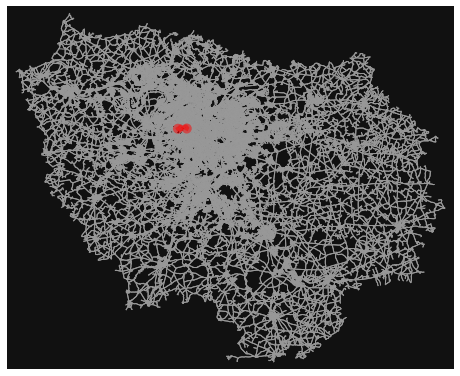

In [71]:
orig = ox.distance.nearest_nodes(G, X=2.27532, Y=48.86756)
dest = ox.distance.nearest_nodes(G, X=2.23466 , Y=48.86822)
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
dist=round(sum(edge_lengths))